In [48]:
import numpy as np
np.set_printoptions(precision=4)
from scipy.stats import norm, multivariate_normal as mvn
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [49]:
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)

In [50]:
""" This seems to be the best metric for now"""
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_vals = pdf(grids)

def sample_from_density_2d(p_vals, x_grid, y_grid, n_samples = 10000):
    """Sample from 2D density given over meshgrid"""
    H, W = p_vals.shape
    flat_p = p_vals.ravel()
    flat_p /= flat_p.sum()  # Normalize

    indices = np.random.choice(H * W, size=n_samples, p=flat_p)
    x_flat = x_grid.ravel()[indices]
    y_flat = y_grid.ravel()[indices]
    return np.stack([x_flat, y_flat], axis=1)

In [51]:
# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-4)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt

In [52]:
# Parameters
dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
T = 100000
dt = 1/T            
v_max = .1 * dt_emp * T 
d = 2                
n_dirs = 200

# Projection directions (unit vectors on S^1)
#angles = np.random.uniform(0, 2 * np.pi, size=n_dirs)
angles = np.linspace(0, 2 * np.pi, n_dirs)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  

# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = np.array([.5,.5])#np.random.uniform(low=0.0, high=1.0, size=(2,))

Advantages: Algorithmn is more versatile, works finde for different speeds, increasing velocities, or rather larger delta ts computations!
No issues with periodicity, are basis outside of the domain
Higher accuracy as speed increases!

i.e works better on coarser grid major bottle kneck approximation of cdf!

In [53]:
from sortedcontainers import SortedList

sls = [SortedList() for _ in range(n_dirs)]
proj = np.zeros((T, n_dirs))
for i in range(1, T):
    if i % 1000 == 0 and i != 1:
        print(f"Step {i}/{T}")
    # Model-based PDF, CDF, projections
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, f[i - 1], means, covs, weights)
    proj[i - 1] = proj_xt
    # SortedList method
    F_push = np.empty(n_dirs, dtype=float)
    for j in range(n_dirs):
        cnt_prev = sls[j].bisect_right(proj_xt[j])
        F_push[j] = (cnt_prev + 1) / i
        sls[j].add(proj_xt[j])
        
    deltas = F_push - cdfs
    pdfs = np.maximum(pdfs, 1e-6)
    grad = 1.5 * (deltas / (2 * pdfs * dt)) - 1 / (2 * pdfs) + (np.sign(deltas) / (2 * pdfs))
    grad = grad @ dirs
    grad /= np.linalg.norm(grad)
    f[i] = f[i - 1] + v_max * dt * grad

Step 1000/100000
Step 2000/100000
Step 3000/100000
Step 4000/100000
Step 5000/100000
Step 6000/100000
Step 7000/100000
Step 8000/100000
Step 9000/100000
Step 10000/100000
Step 11000/100000
Step 12000/100000
Step 13000/100000
Step 14000/100000
Step 15000/100000
Step 16000/100000
Step 17000/100000
Step 18000/100000
Step 19000/100000
Step 20000/100000
Step 21000/100000
Step 22000/100000
Step 23000/100000
Step 24000/100000
Step 25000/100000
Step 26000/100000
Step 27000/100000
Step 28000/100000
Step 29000/100000
Step 30000/100000
Step 31000/100000
Step 32000/100000
Step 33000/100000
Step 34000/100000
Step 35000/100000
Step 36000/100000
Step 37000/100000
Step 38000/100000
Step 39000/100000
Step 40000/100000
Step 41000/100000
Step 42000/100000
Step 43000/100000
Step 44000/100000
Step 45000/100000
Step 46000/100000
Step 47000/100000
Step 48000/100000
Step 49000/100000
Step 50000/100000
Step 51000/100000
Step 52000/100000
Step 53000/100000
Step 54000/100000
Step 55000/100000
Step 56000/100000
S

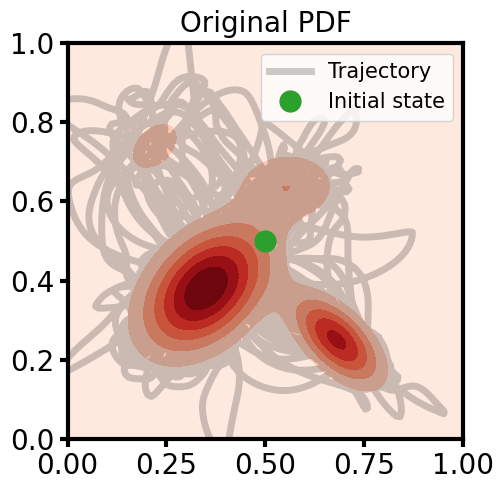

In [54]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(f[::10,0], f[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(f[0,0], f[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

2025-08-13 15:35:11,234 |  WARNING | legend.py:1236 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


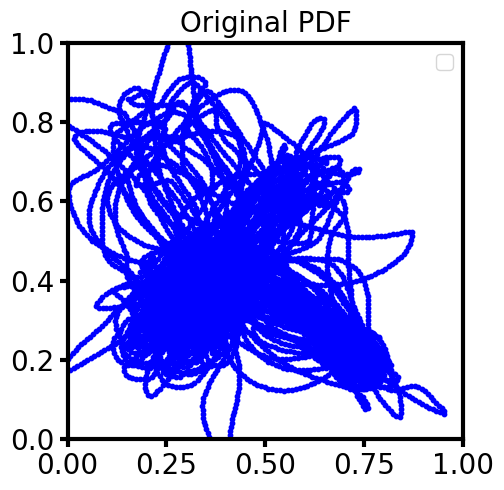

In [55]:
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(f[::10, 0], f[::10, 1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

In [56]:
import infomeasure as im
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
mu_samples_test = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
print(im.kld(f,mu_samples, approach='metric'), 'emp')
print(im.kld(mu_samples_test, mu_samples, approach='metric'), 'opt')

2.0148308360536613 emp
-0.04615976950371703 opt
